In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('../../Data/maize.csv')

In [4]:
target = data['price']
features = data.drop('price', axis=1)

In [5]:
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=100)

In [7]:
feature_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1535 entries, 1279 to 1544
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              1535 non-null   float64
 1   month                             1535 non-null   int64  
 2   years_since_start                 1535 non-null   int64  
 3   past_three_months_mean_price      1535 non-null   float64
 4   past_six_months_mean_price        1535 non-null   float64
 5   past_twelve_months_mean_price     1535 non-null   float64
 6   yearly_average_price              1535 non-null   float64
 7   monthly_average_price             1535 non-null   float64
 8   market_average_price              1535 non-null   float64
 9   commodity_yearly_average_price    1535 non-null   float64
 10  commodity_monthly_average_price   1535 non-null   float64
 11  market_Arusha (urban)             1535 non-null   int64  
 12  market_B

In [10]:
models = {
    # 'Linear Regression' : LinearRegression(),
    'Decision Tree' : DecisionTreeRegressor(max_depth=1000, random_state=42),
    # 'Random Forest' : RandomForestRegressor(max_depth=1000, n_estimators=1000, random_state=42),
    # 'Gradient Boosting' : GradientBoostingRegressor(n_estimators=1000, max_depth=1000),
    # 'KNN Regressor' : KNeighborsRegressor(n_neighbors=5),
    # 'XGBoost Regressor': XGBRegressor(n_estimators=1000, max_depth=1000),
    # 'CatBoost Regressor': CatBoostRegressor(n_estimators=1000, max_depth=16, logging_level='Silent'),
    # 'LightGBM Regressor': lgb.LGBMRegressor( 
    #     objective='regression', 
    #     metric='mse', 
    #     feature_fraction=0.8,
    #     bagging_fraction=0.8,
    #     bagging_freq=5,
    #     verbose=0,
    #     n_estimators=100,
    #     max_depth=1000,
    #     verbosity=-1,
    #     silent=True
    # )
}

param_grids = {
    'Linear Regression': {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'n_jobs' : [10, 20, 60, 80, 100],
        'positive' : [True, False]
    },
    'Decision Tree': {
        'min_samples_split': [2, 5, 7, 11, 50, 80, 100],
        'min_samples_leaf': [3, 7, 12, 30],
    },
    'Random Forest': {
        'min_samples_split': [2, 5, 7, 11, 50, 80, 100],
        'min_samples_leaf': [3, 7, 12, 30],
        'bootstrap': [True, False],
    },
    'Gradient Boosting': {
        'learning_rate': [0.01, 0.05, 0.1, 0.11, 0.15, 0.2],
        'min_samples_split': [2, 5, 7, 11, 50, 80, 100],
        'min_samples_leaf': [3, 7, 12, 30],
    },
    'KNN Regressor': {
        'n_neighbors': [1, 3, 5, 10, 20],
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
    },
    'XGBoost Regressor': {
        'learning_rate': [0.01, 0.05, 0.1, 0.11, 0.15, 0.2],
    },
    'CatBoost Regressor': {
        'learning_rate': [0.01, 0.05, 0.1, 0.11, 0.15, 0.2],
    },
    'LightGBM Regressor': {
        'boosting_type': ['gbdt', 'goss', 'rf', 'dart'],
        'learning_rate': [0.01, 0.05, 0.1, 0.11, 0.15, 0.2],
        'num_leaves': [3, 7, 12, 30],
    },
}


best_models = {}

tuneBar = tqdm(models.items(), desc="Tuning Models")

for name, model in tuneBar:
    if name in param_grids:
        param_grid = param_grids[name]
        with tqdm(total=1, desc=f"Tuning Model: {name}") as insideBar:
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                                            scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
            grid_search.fit(feature_train, target_train)
            insideBar.update(1)
        best_model = grid_search.best_estimator_
        best_models[name] = best_model
    else:
        best_models[name] = model

Tuning Models:   0%|          | 0/1 [00:00<?, ?it/s]

Tuning Model: Decision Tree:   0%|          | 0/1 [00:00<?, ?it/s]

Training Models:   0%|          | 0/1 [00:00<?, ?it/s]

Training Model: Decision Tree:   0%|          | 0/1 [00:00<?, ?it/s]

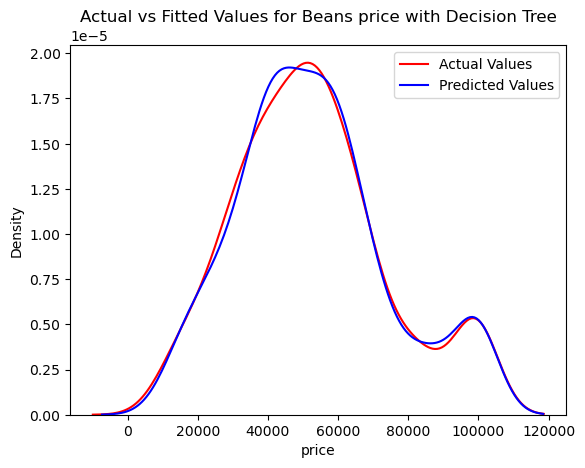

,Model Name,MAE,MSE,RMSE,R^2
0,Decision Tree,3764.095638,2.849151e+07,5337.743767,93.9133%


In [11]:
results = {
    'Model Name': [],
    'MAE' : [],
    'MSE' : [],
    'RMSE' : [],
    'R^2' : []
}


trainBar = tqdm(best_models.items(), desc="Training Models")

for name, model in trainBar:
    with tqdm(total=1, desc=f"Training Model: {name}") as insideBar:
        model.fit(feature_train, target_train)
        pickle.dump(model, open(f'../Models/Maize/Maize_model_{name}.pkl', 'wb'))
        model = pickle.load(open(f'../Models/Maize/Maize_model_{name}.pkl', 'rb'))
        predictions = model.predict(feature_test)
        insideBar.update(1)

    mae = mean_absolute_error(target_test, predictions)
    mse = mean_squared_error(target_test, predictions)
    rmse = mean_squared_error(target_test, predictions, squared=False)
    r2 = r2_score(target_test, predictions)

    results['Model Name'].append(name)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R^2'].append(f'{r2 * 100:.4f}%')

    ax1 = sns.distplot(target_test, hist=False, color="r", label="Actual Values")
    sns.distplot(predictions, hist=False, color="b", label="Predicted Values" , ax=ax1)
    plt.title(f'Actual vs Fitted Values for Beans price with {name}')
    plt.legend()
    plt.show()
    print()
    plt.close()

results = pd.DataFrame(results)
results